In [1]:
import pandas as pd
import numpy as np
import scipy as sp
%matplotlib notebook
import matplotlib.pyplot as plt
from changedetect.kuncheva2014 import get_change_value
import warnings
warnings.filterwarnings('ignore')

In [4]:
def flow_modeling_procedures(groupby_n, regr):
    one_day_n = int(24*(60/groupby_n))
    # Year 2020 data
    # read flow data
    p1_2020 = pd.read_csv('../二期/EndUserData2020P2.csv')
    # perform time integration on data
    p1_2020 = p1_2020.groupby(p1_2020.index // groupby_n).mean()
    # select data with flow larger than 500 (ignore small flow data)
    p1_2020_nonzero = p1_2020.loc[p1_2020['NB2_S_x_NYZ_x_x_Fcw_x']>500]
    # read on/off state data
    p1_2020_state = pd.read_csv('../二期/EndUserData2020P2CWPState.csv')
    # perform time integration on data
    p1_2020_state = p1_2020_state.groupby(p1_2020_state.index // groupby_n).mean()
    # select data with flow larger than 500 (ignore small flow data)
    p1_2020_state_nonzero = p1_2020_state.loc[p1_2020['NB2_S_x_NYZ_x_x_Fcw_x']>500]
    # if the pump is off, set the frequency to zero
    p1_2020_nonzero['NB2_S_1_NYZ_cwp_9_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_9_HzSPR_x']\
                                            * p1_2020_state_nonzero['NB2_S_1_NYZ_cwp_9_State_x']
    p1_2020_nonzero['NB2_S_1_NYZ_cwp_10_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_10_HzSPR_x']\
                                            * p1_2020_state_nonzero['NB2_S_1_NYZ_cwp_10_State_x']
    p1_2020_nonzero['NB2_S_1_NYZ_cwp_11_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_11_HzSPR_x']\
                                            * p1_2020_state_nonzero['NB2_S_1_NYZ_cwp_11_State_x']
    p1_2020_nonzero['NB2_S_1_NYZ_cwp_12_HzSPR_x'] = p1_2020_nonzero['NB2_S_1_NYZ_cwp_12_HzSPR_x']\
                                            * p1_2020_state_nonzero['NB2_S_1_NYZ_cwp_12_State_x']
    # get pressure difference
    p1_2020_nonzero['p_diff'] =  p1_2020_nonzero['NB2_S_1_NYZ_sys_x_PcwOut_x'] - p1_2020_nonzero['NB2_S_1_NYZ_sys_x_PcwIn_x']
    # Year 2021 data
    # same procedure apply to 2021 data
    p1_2021 = pd.read_csv('../二期/EndUserData2021P2_fix.csv')
    p1_2021_nonidx = np.where(pd.isnull(p1_2021).any(1) == 1)[0]
    p1_2021 = p1_2021.drop(p1_2021_nonidx)
    p1_2021 = p1_2021.groupby(p1_2021.index // groupby_n).mean()
    p1_2021_nonzero = p1_2021.loc[p1_2021['NB2_S_x_NYZ_x_x_Fcw_x']>500]
    
    p1_2021_state = pd.read_csv('../二期/EndUserData2021P2CWPState.csv')
    p1_2021_state = p1_2021_state.drop(p1_2021_nonidx)
    p1_2021_state = p1_2021_state.groupby(p1_2021_state.index // groupby_n).mean()
    p1_2021_state_nonzero = p1_2021_state.loc[p1_2021['NB2_S_x_NYZ_x_x_Fcw_x']>500]
    
    
    p1_2021_nonzero['NB2_S_1_NYZ_cwp_9_HzSPR_x'] = p1_2021_nonzero['NB2_S_1_NYZ_cwp_9_HzSPR_x']\
                                            * p1_2021_state_nonzero['NB2_S_1_NYZ_cwp_9_State_x']
    p1_2021_nonzero['NB2_S_1_NYZ_cwp_10_HzSPR_x'] = p1_2021_nonzero['NB2_S_1_NYZ_cwp_10_HzSPR_x']\
                                            * p1_2021_state_nonzero['NB2_S_1_NYZ_cwp_10_State_x']
    p1_2021_nonzero['NB2_S_1_NYZ_cwp_11_HzSPR_x'] = p1_2021_nonzero['NB2_S_1_NYZ_cwp_11_HzSPR_x']\
                                            * p1_2021_state_nonzero['NB2_S_1_NYZ_cwp_11_State_x']
    p1_2021_nonzero['NB2_S_1_NYZ_cwp_12_HzSPR_x'] = p1_2021_nonzero['NB2_S_1_NYZ_cwp_12_HzSPR_x']\
                                            * p1_2021_state_nonzero['NB2_S_1_NYZ_cwp_12_State_x']
    p1_2021_nonzero['p_diff'] =  p1_2021_nonzero['NB2_S_1_NYZ_sys_x_PcwOut_x'] - p1_2021_nonzero['NB2_S_1_NYZ_sys_x_PcwIn_x']
    
    
    # regression
    # 2020 data
    # prepare training and validataion data set
    reg1_x_20 = p1_2020_nonzero[['NB2_S_1_NYZ_cwp_9_HzSPR_x', 'NB2_S_1_NYZ_cwp_10_HzSPR_x',
                          'NB2_S_1_NYZ_cwp_11_HzSPR_x', 'NB2_S_1_NYZ_cwp_12_HzSPR_x',
                          'p_diff']].values
    reg1_y_20 = p1_2020_nonzero['NB2_S_x_NYZ_x_x_Fcw_x'].values
    reg1_data_len_20 = len(reg1_x_20)
    reg1_train_len_20 = int(reg1_data_len_20 * 0.6)
    reg1_x_train_20 = reg1_x_20[0: reg1_train_len_20]
    reg1_x_valid_20 = reg1_x_20[reg1_train_len_20: ]
    reg1_y_train_20 = reg1_y_20[0: reg1_train_len_20]
    reg1_y_valid_20 = reg1_y_20[reg1_train_len_20: ]
    # 2021 data
    # prepare training and validataion data set
    reg1_x_21 = p1_2021_nonzero[['NB2_S_1_NYZ_cwp_9_HzSPR_x', 'NB2_S_1_NYZ_cwp_10_HzSPR_x',
                          'NB2_S_1_NYZ_cwp_11_HzSPR_x', 'NB2_S_1_NYZ_cwp_12_HzSPR_x',
                          'p_diff']].values
    reg1_y_21 = p1_2021_nonzero['NB2_S_x_NYZ_x_x_Fcw_x'].values
    reg1_data_len_21 = len(reg1_x_21)
    reg1_train_len_21 = int(reg1_data_len_21 * 0.6)
    reg1_x_train_21 = reg1_x_21[0: reg1_train_len_21]
    reg1_x_valid_21 = reg1_x_21[reg1_train_len_21: ]
    reg1_y_train_21 = reg1_y_21[0: reg1_train_len_21]
    reg1_y_valid_21 = reg1_y_21[reg1_train_len_21: ]
    regr.fit(reg1_x_20, reg1_y_20)
    print('Training R: %s'%regr.score(reg1_x_train_20, reg1_y_train_20))
    # 2020 validation data plot
    reg1_y_pred_20 = regr.predict(reg1_x_valid_20)
    fig, ax=plt.subplots(figsize = (20, 10))
    ax.plot(reg1_y_valid_20, color = 'blue', label = 'true')
    ax.plot(reg1_y_pred_20, color = 'green', label = 'pred')
    for x_i in range(0, len(reg1_y_pred_20), one_day_n):
        ax.axvline(x=x_i, ymin=0, ymax=300)
        ax.text(x=x_i, y=300, s='%s'%(x_i/one_day_n), fontsize=12)
    ax.legend()
    ax.set_title('Validation using 2020 data')
    fig.show()
    print('Validation R: %s'%regr.score(reg1_x_valid_20, reg1_y_valid_20))
    # 2020 validation data daily distribution change vs prediction error
    day_range = 1 ################
    daily_errors = []
    daily_dist_changes = []
    for day_i in range(0, int(len(reg1_y_valid_20)/one_day_n), day_range):
        new_data = reg1_x_valid_20[day_i * one_day_n: (day_i + day_range) * one_day_n]
        new_data_pred_y = regr.predict(new_data)
        new_data_true_y = reg1_y_valid_20[day_i * one_day_n: (day_i + day_range) * one_day_n]
        new_data_r2 = regr.score(new_data, new_data_true_y)#np.mean(np.abs(new_data_pred_y - new_data_true_y)/new_data_true_y)
        daily_errors.append(new_data_r2)
        change_val = get_change_value(org_data=reg1_x_train_20, new_data=new_data, 
                                     pca_exp_thres=0.25, cluster_n=3)
        daily_dist_changes.append(change_val)
    fig, ax=plt.subplots(figsize = (5, 5))
    ax.scatter(daily_dist_changes, daily_errors)
    ax.set_title('2020 validation data R2 vs. distribution change')
    fig.show()
    # print r2 and distribution change
    r2dist_df = pd.DataFrame(np.array([daily_dist_changes, daily_errors]).T)
    r2dist_df.columns = ['dist change', 'r2']
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    print(r2dist_df)
    # 2021 test data plot
    reg1_y_pred_21 = regr.predict(reg1_x_21)
    fig, ax=plt.subplots(figsize = (20, 5))
    ax.plot(reg1_y_21, color = 'blue', label = 'true')
    ax.plot(reg1_y_pred_21, color = 'green', label = 'pred')
    for x_i in range(0, len(reg1_y_21), one_day_n):
        ax.axvline(x=x_i, ymin=0, ymax=300)
        ax.text(x=x_i, y=300, s='%s'%(x_i/one_day_n), fontsize=12)
    ax.legend()
    ax.set_title('Test using 2021 data')
    fig.show()
    print('Test in 2021 R: %s'%regr.score(reg1_x_21, reg1_y_21))
    # distribution change
    print('Distribution difference between 2020 training and validation dataset is: %s'%get_change_value(org_data=reg1_x_train_20, new_data=reg1_x_valid_20, 
                 pca_exp_thres=0.25, cluster_n=3))
    print('Distribution difference between 2020 and 2021 dataset is: %s'%get_change_value(org_data=reg1_x_20, new_data=reg1_x_21, 
                 pca_exp_thres=0.25, cluster_n=3))
    daily_dist_changes = []
    daily_errors = []
    print(reg1_data_len_21)
    print(one_day_n)
    for day_i in range(0, int(reg1_data_len_21/one_day_n), day_range):
        new_data = reg1_x_21[day_i * one_day_n: (day_i + day_range) * one_day_n]
        new_data_pred_y = regr.predict(new_data)
        new_data_true_y = reg1_y_21[day_i * one_day_n: (day_i + day_range) * one_day_n]
        new_data_r2 = regr.score(new_data, new_data_true_y)#np.mean(np.abs(new_data_pred_y - new_data_true_y)/new_data_true_y)
        daily_errors.append(new_data_r2)
        change_val = get_change_value(org_data=reg1_x_train_20, new_data=new_data, 
                                     pca_exp_thres=0.25, cluster_n=3)
        daily_dist_changes.append(change_val)
    fig, ax=plt.subplots(figsize = (5, 5))
    ax.scatter(daily_dist_changes, daily_errors)
    ax.set_title('R2 vs. distribution change')
    fig.show()
    # print r2 and distribution change
    r2dist_df = pd.DataFrame(np.array([daily_dist_changes, daily_errors]).T)
    r2dist_df.columns = ['dist change', 'r2']
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    print(r2dist_df)
    # perform error analysis using multivariate distribution
    reg1_x_20_mean = np.mean(reg1_x_20, axis = 0)
    reg1_x_20_cov = np.cov(reg1_x_20, rowvar = False)
    reg1_x_dist = sp.stats.multivariate_normal(mean = reg1_x_20_mean, 
                                         cov = reg1_x_20_cov)
    valid20_dist2mean = []
    for train_pt in reg1_x_valid_20:
        test_dist2mean = np.matmul(np.matmul((train_pt - reg1_x_20_mean),
                                     np.linalg.inv(reg1_x_20_cov)),
                           (train_pt - reg1_x_20_mean).T)
        valid20_dist2mean.append(test_dist2mean)
    fig, ax=plt.subplots(figsize = (20, 5))
    ax.plot(reg1_y_valid_20, color = 'blue', label = 'true')
    ax.plot(reg1_y_pred_20, color = 'green', label = 'pred')
    ax2 = ax.twinx()
    ax2.plot(valid20_dist2mean, color = 'red', label = 'dist2mean')
    ax.legend()
    ax2.legend()
    ax.set_title('Validation using 2020 data')
    fig.show()
    test21_dist2mean = []
    test21_mapes = np.abs(reg1_y_pred_21 - reg1_y_21)/reg1_y_21
    for train_pt in reg1_x_21:
        test_dist2mean = np.matmul(np.matmul((train_pt - reg1_x_20_mean),
                                     np.linalg.inv(reg1_x_20_cov)),
                           (train_pt - reg1_x_20_mean).T)
        test21_dist2mean.append(test_dist2mean)
    fig, ax=plt.subplots(figsize = (20, 5))
    ax.plot(reg1_y_21, color = 'blue', label = 'true')
    ax.plot(reg1_y_pred_21, color = 'green', label = 'pred')
    ax2 = ax.twinx()
    ax2.plot(test21_dist2mean, color = 'red', label = 'dist2mean')
    ax.legend()
    ax.set_title('Test using 2021 data')
    fig.show()
    
    x20_dist2mean = []
    for train_pt in reg1_x_20:
        test_dist2mean = np.matmul(np.matmul((train_pt - reg1_x_20_mean),
                                     np.linalg.inv(reg1_x_20_cov)),
                           (train_pt - reg1_x_20_mean).T)
        x20_dist2mean.append(test_dist2mean)
        
    fig, ax=plt.subplots(figsize = (5, 5))
    ax.scatter(test21_dist2mean, test21_mapes)
    ax.set_title('dist2mean vs. mape')
    fig.show()
    # dist2mean cmp
    fig, ax=plt.subplots(figsize = (20, 5))
    ax.plot(x20_dist2mean, color = 'blue', label = '2020 dist2mean')
    ax.plot(test21_dist2mean, color = 'green', label = '2021 dist2mean')
    ax.legend()
    ax.set_title('2020 vs 2021 dist2mean')

Training R: 0.9968458817235302


<IPython.core.display.Javascript object>


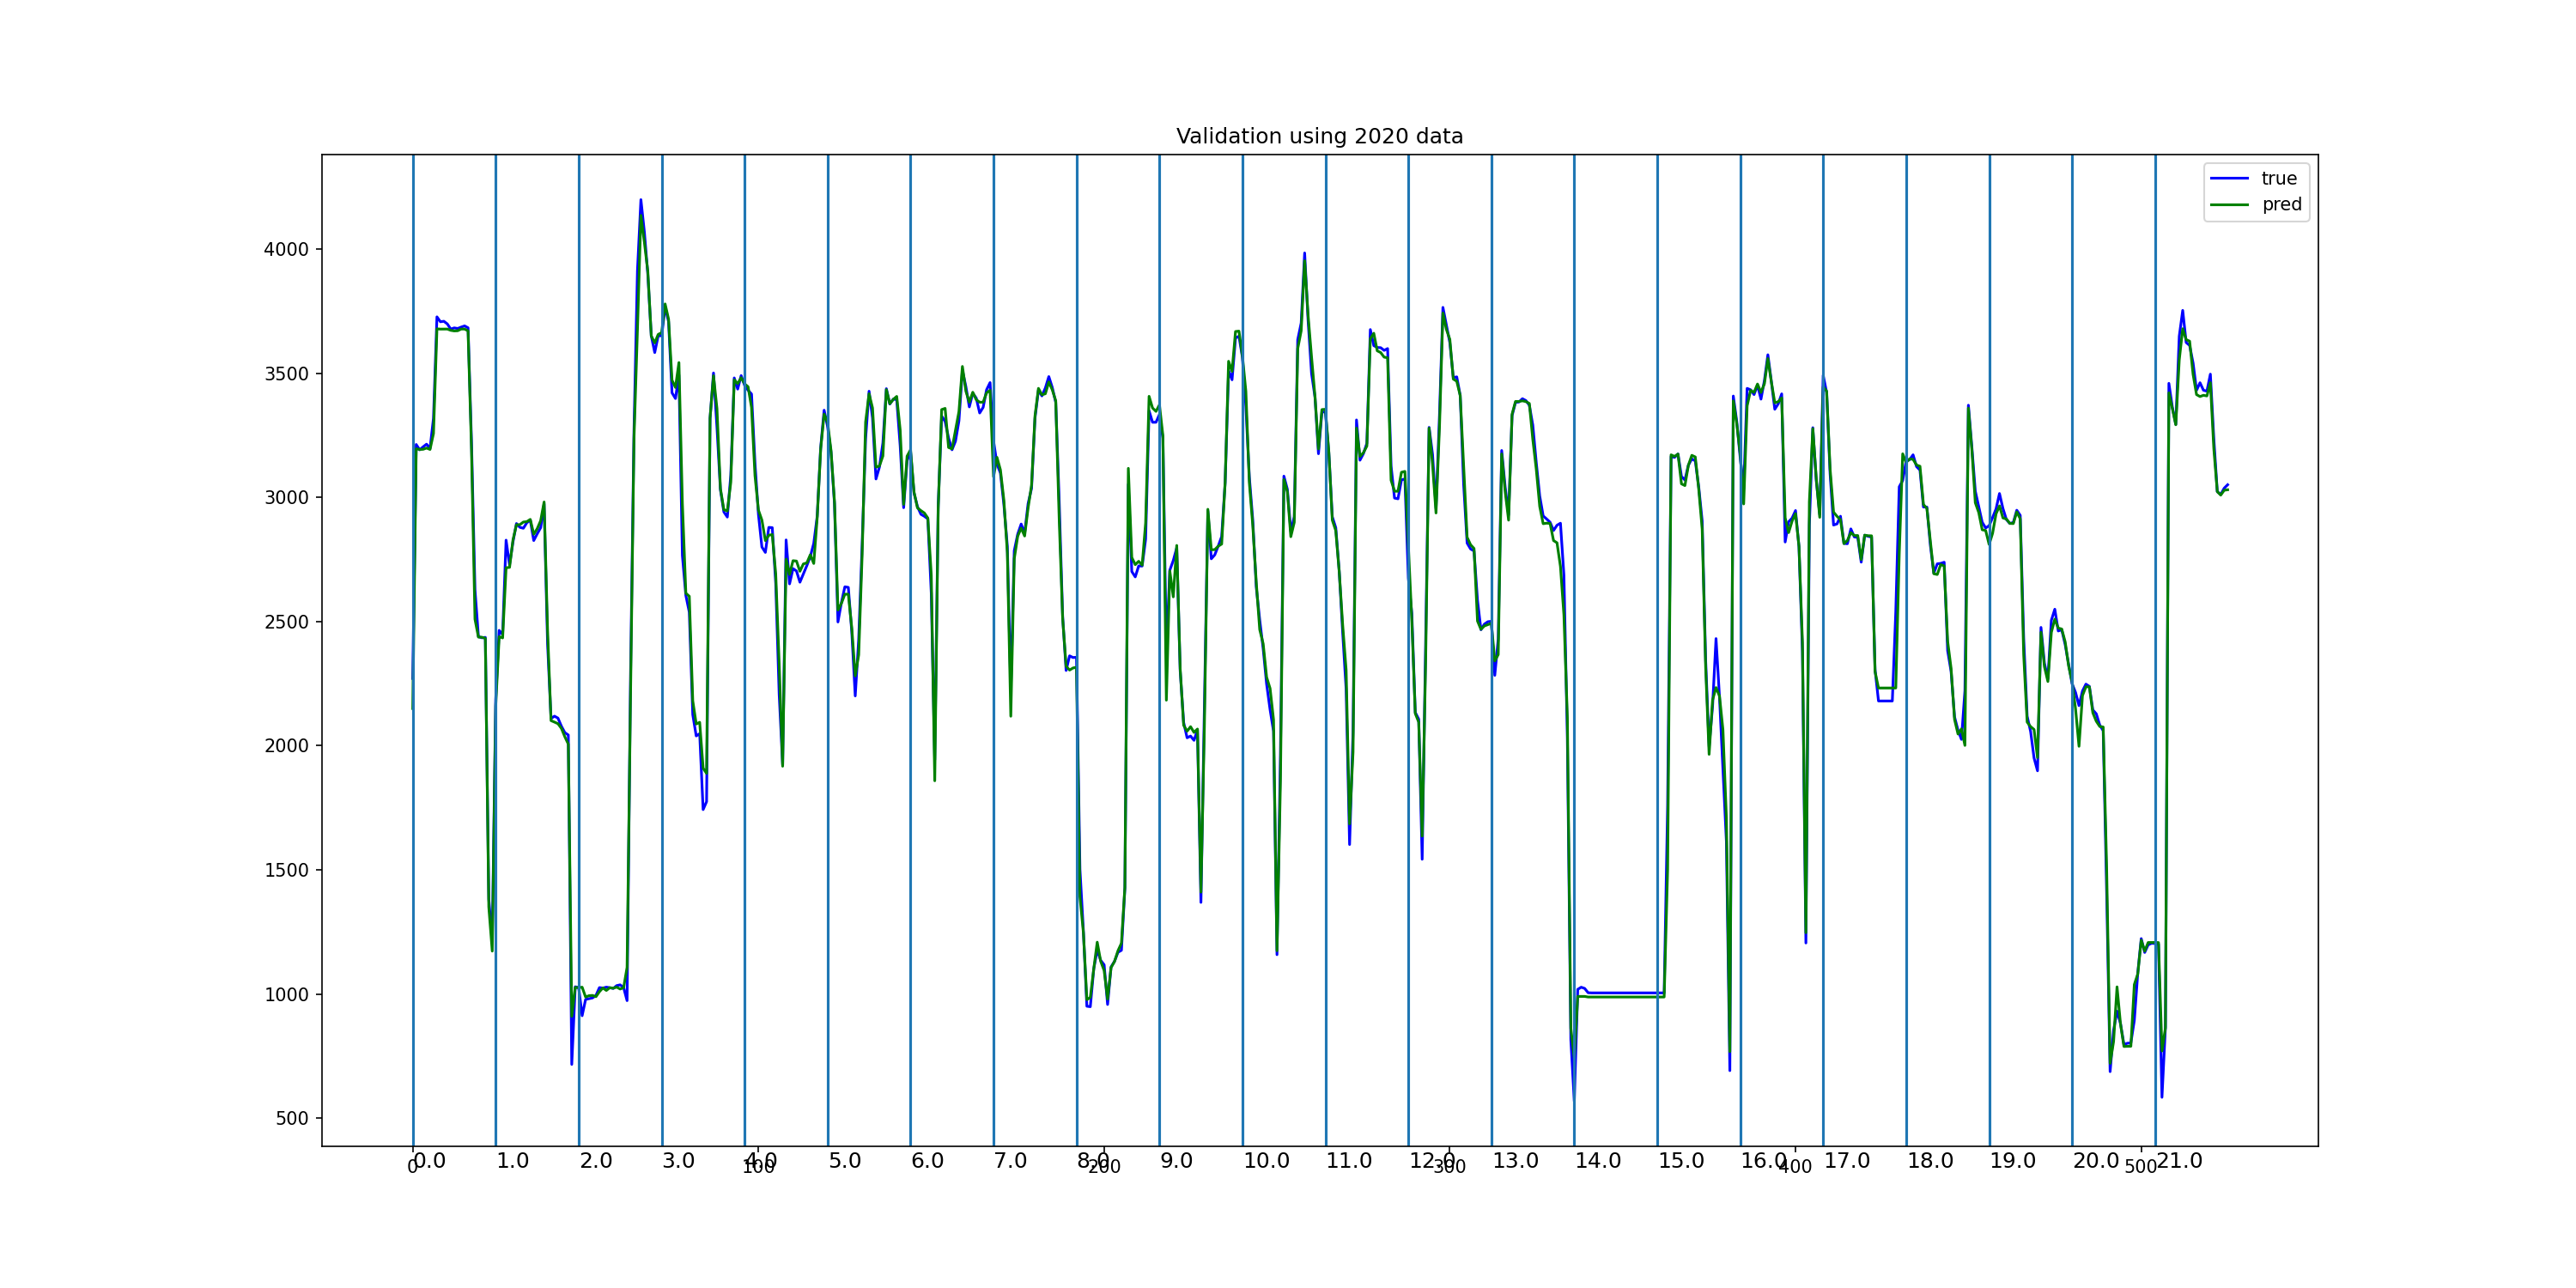

Validation R: 0.9959858577289121


<IPython.core.display.Javascript object>


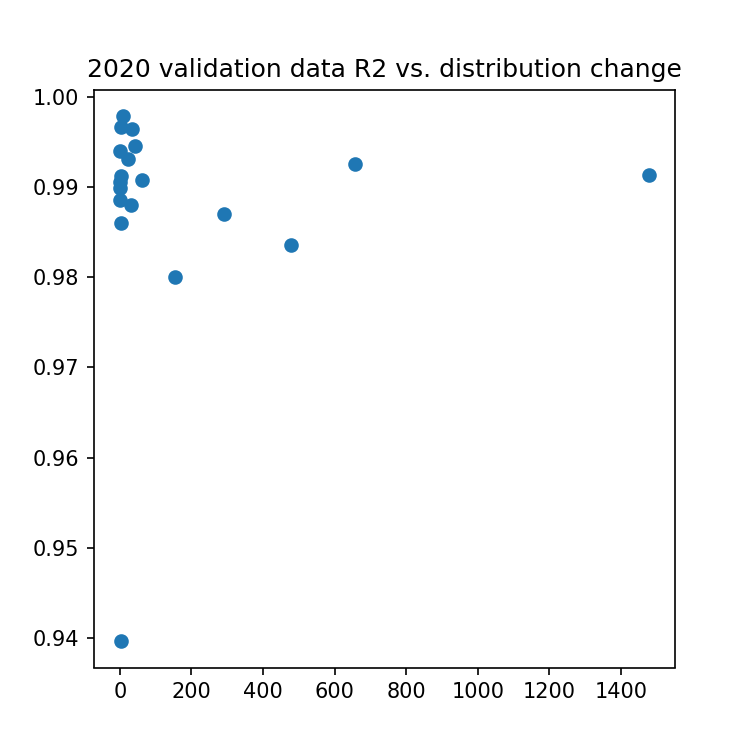

    dist change    r2
0         3.563 0.997
1       655.858 0.992
2           inf 0.998
3        30.615 0.988
4       155.006 0.980
5         0.940 0.990
6         0.707 0.991
7       290.804 0.987
8         7.770 0.998
9        62.809 0.991
10       33.324 0.996
11       43.293 0.995
12       23.539 0.993
13        1.214 0.989
14          inf 0.791
15        1.872 0.991
16        1.129 0.994
17        3.438 0.940
18      476.946 0.984
19        1.998 0.986
20     1477.239 0.991


<IPython.core.display.Javascript object>


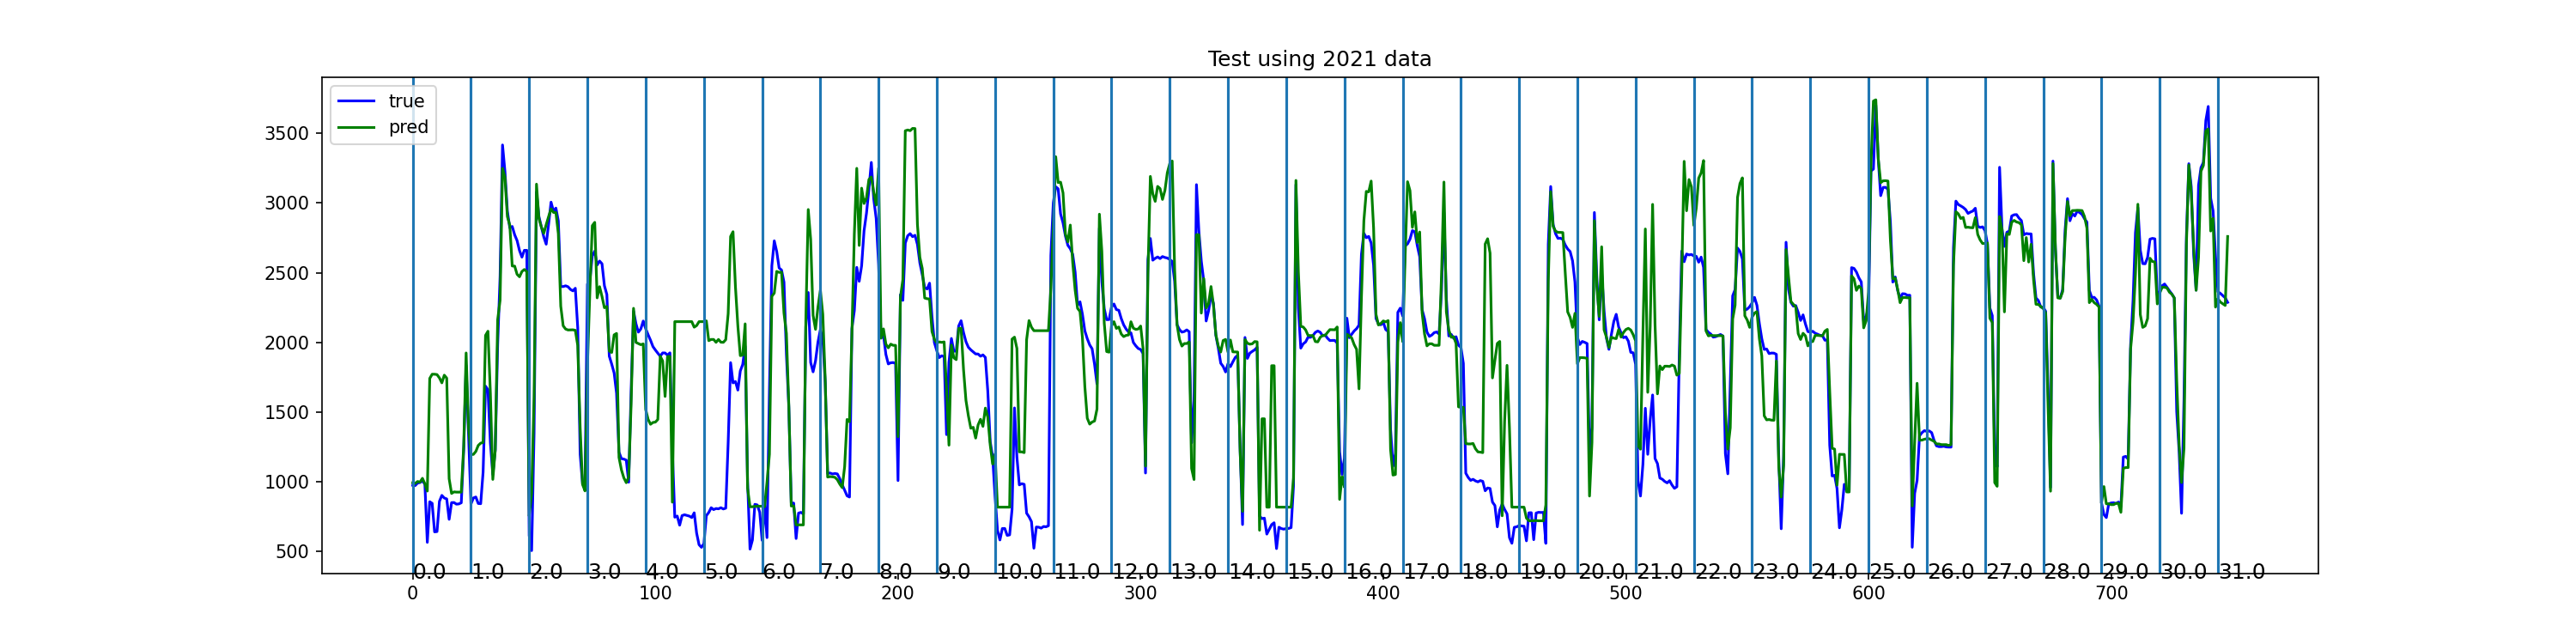

Test in 2021 R: 0.6772681754329177
Distribution difference between 2020 training and validation dataset is: 2.648386159878031
Distribution difference between 2020 and 2021 dataset is: 3.464417781740513
749
24


<IPython.core.display.Javascript object>


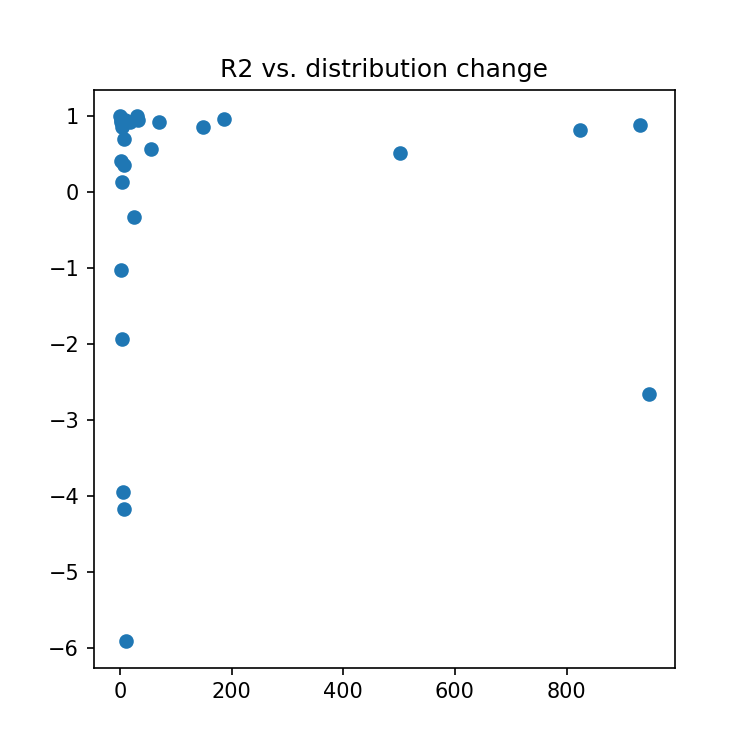

    dist change     r2
0         4.944 -3.948
1        18.060  0.916
2        32.838  0.941
3         4.178  0.849
4         3.375 -1.932
5       947.019 -2.659
6           inf  0.843
7       932.175  0.882
8         2.842  0.134
9         2.116 -1.030
10        6.352 -4.180
11       55.077  0.568
12        6.612  0.356
13      502.534  0.512
14          inf  0.557
15        3.199  0.958
16      824.530  0.816
17        7.179  0.693
18       11.215 -5.915
19      185.849  0.959
20      149.541  0.858
21       25.537 -0.336
22        2.432  0.405
23          inf  0.692
24       70.811  0.922
25        8.285  0.941
26        0.364  0.992
27        1.165  0.913
28       29.685  0.993
29        1.471  0.940
30        4.557  0.941


<IPython.core.display.Javascript object>


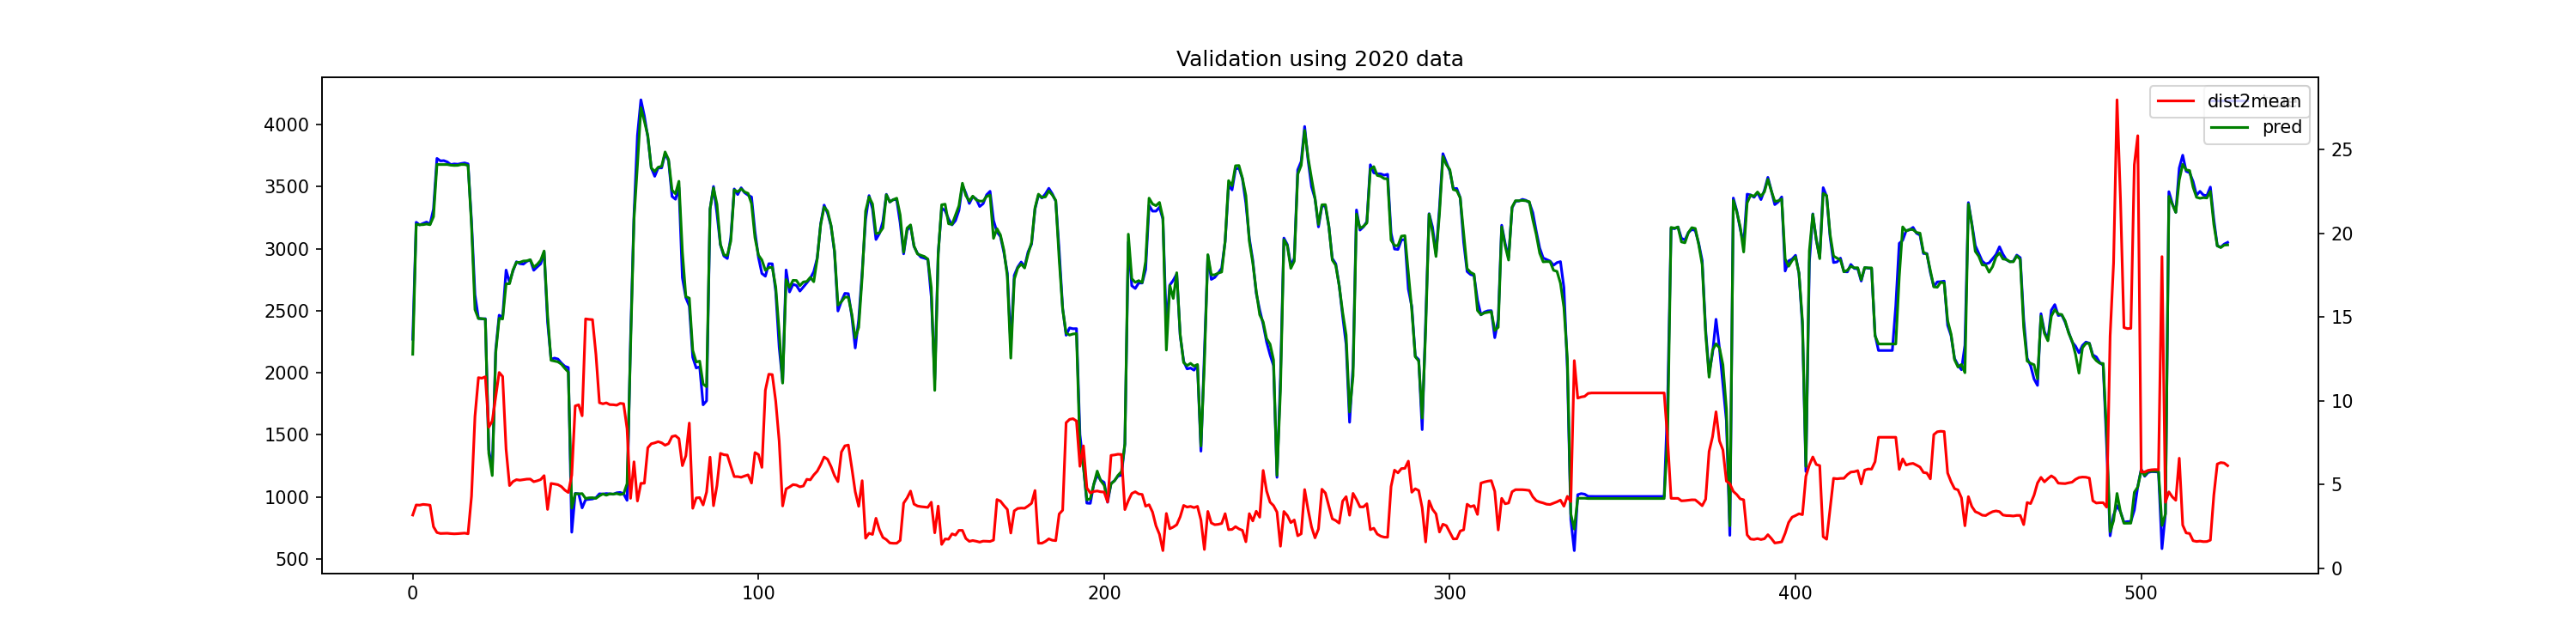

<IPython.core.display.Javascript object>


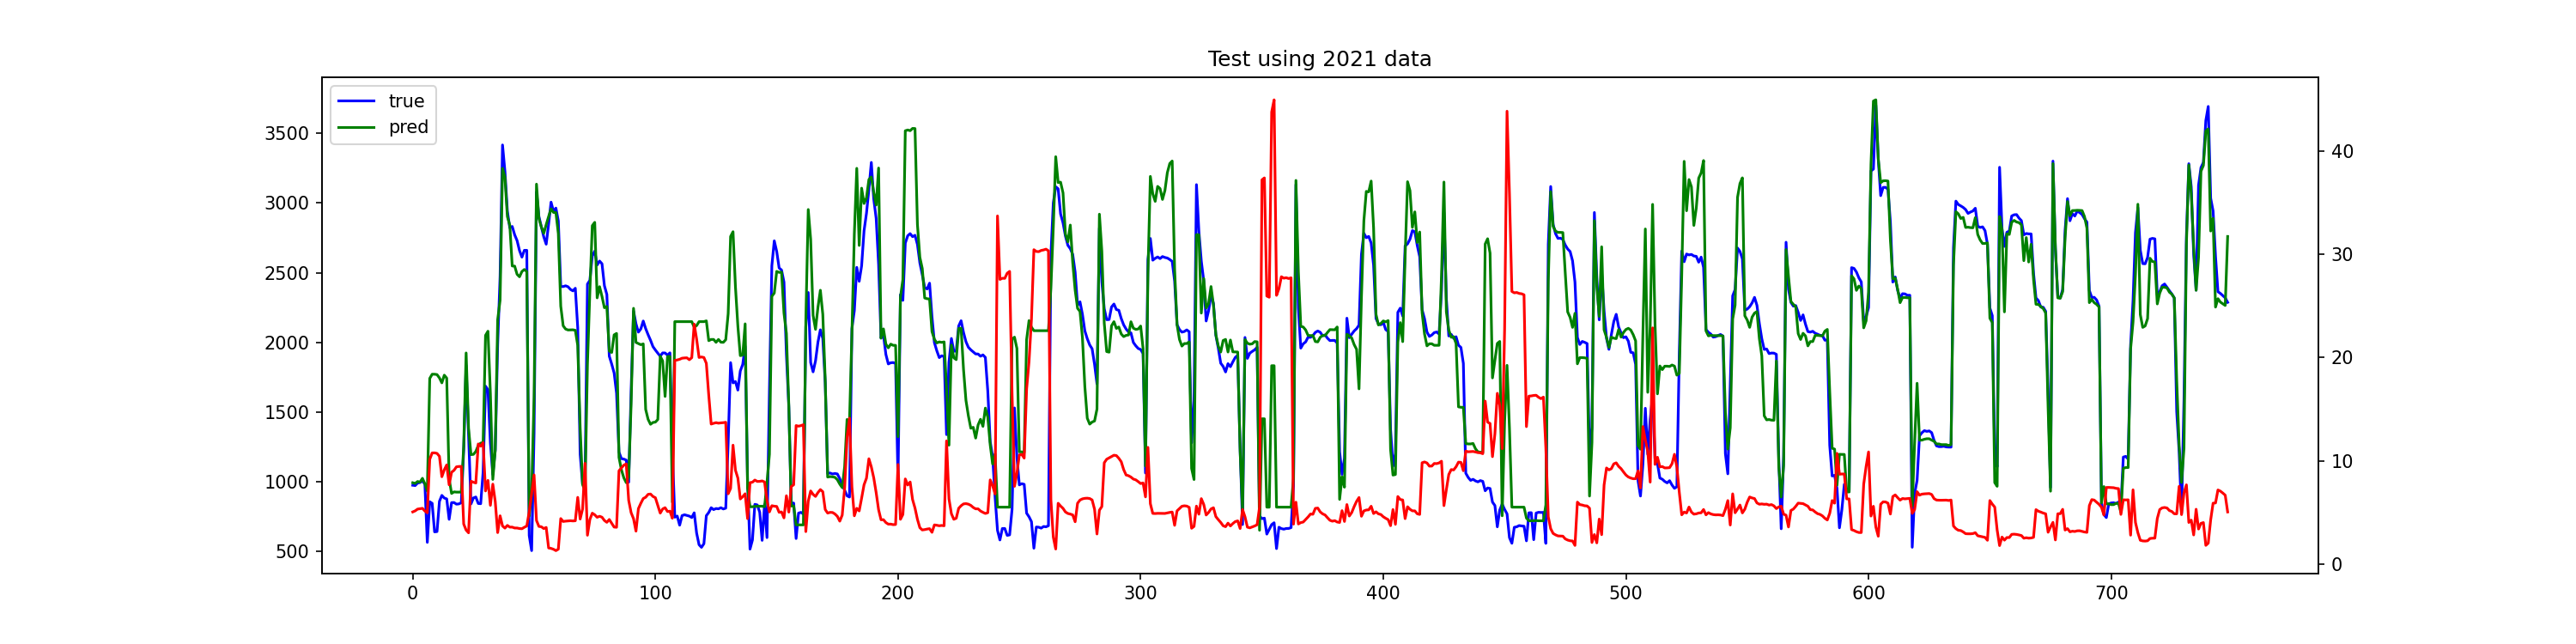

<IPython.core.display.Javascript object>


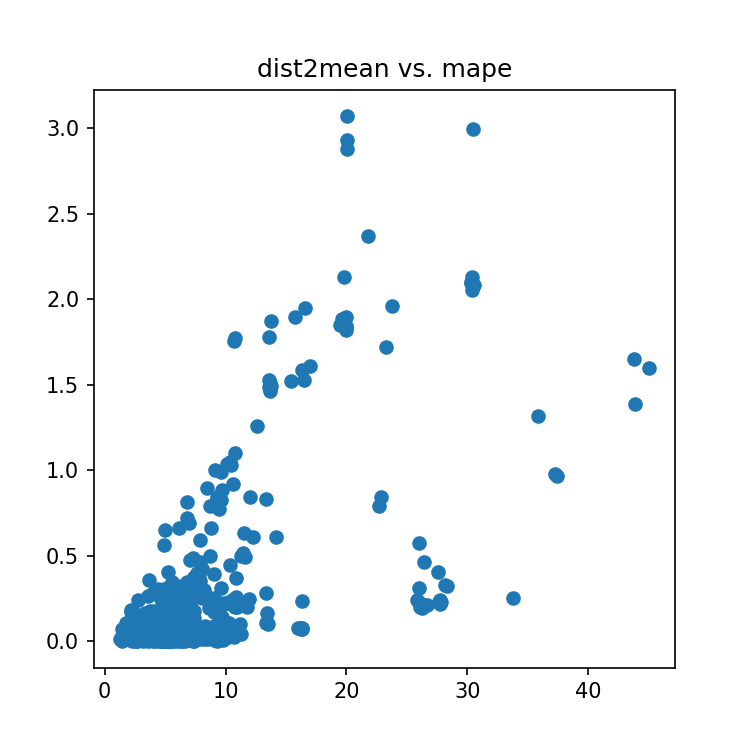

<IPython.core.display.Javascript object>


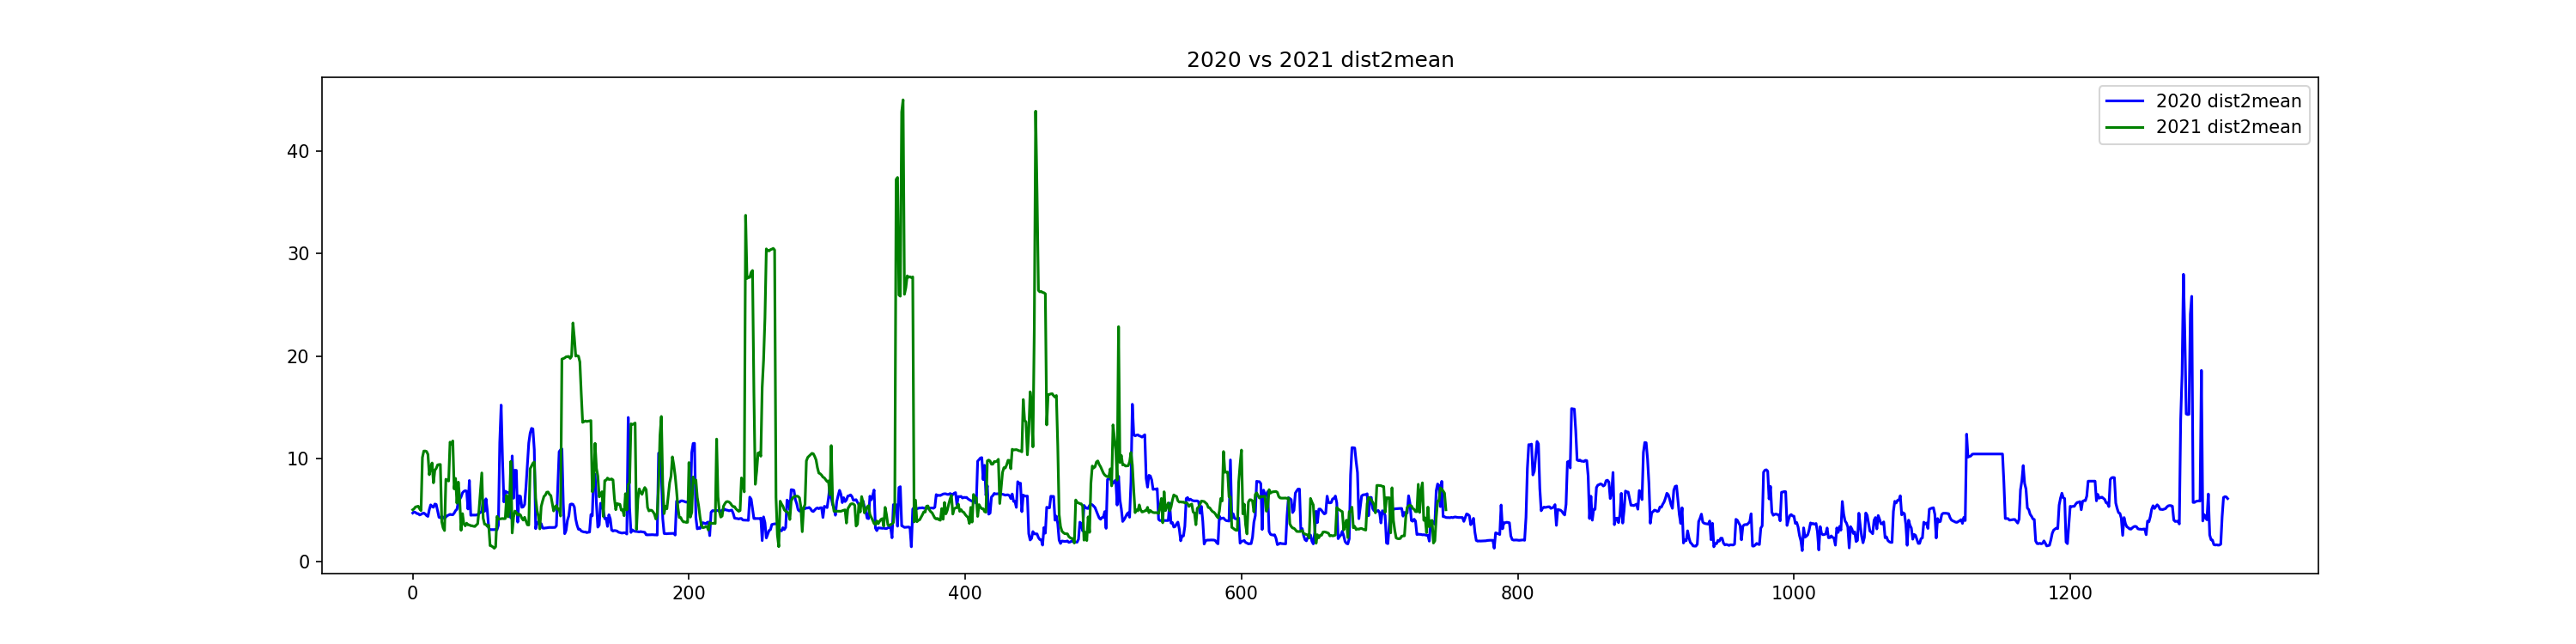

In [5]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=10, random_state=0)
groupby_n = 60
flow_modeling_procedures(groupby_n, regr)